In [ ]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
def count_turns(labyrinth):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Rechts, Unten, Links, Oben
    num_turns = 0

    for i in range(1, labyrinth.shape[0] - 1):
        for j in range(1, labyrinth.shape[1] - 1):
            if labyrinth[i, j] == 1:
                valid_neighbors = 0
                for dx, dy in directions:
                    ni, nj = i + dx, j + dy
                    if labyrinth[ni, nj] == 1:
                        valid_neighbors += 1
                if valid_neighbors == 2:  # Zwei gültige Nachbarn bedeuten eine Richtungsänderung
                    num_turns += 1

    return num_turns

In [ ]:

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_bert.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_229999_bert.pt' 


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt'

path = "SavedModels/Synthetic/"
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEProb500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_hollowCEProb500K.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-05' # 2
config_name = 'config_001_hollowdirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollowdirect.pt' 

path = "SavedModels/SyntheticMasked/"
date = '2023-12-17' # 2
config_name = 'config_001_maskeddirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_maskeddirect.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-05' # 2
config_name = 'config_001_hollowdirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollowdirect.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-28' # 2
config_name = 'config_001_hollowelbo.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_259999_hollowelbo.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-05' # 2
config_name = 'config_001_hollowdirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollowdirect.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_lastunet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_399999_lastunet.pt'

path = "SavedModels/Synthetic/"
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEProb500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_hollowCEProb500K.pt'

path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-25' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_599999_unet14Mlogits.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)


In [ ]:

import numpy as np
steps = [1000]
sampler_name = ['CRMTauL']#, 'CRMTauL']
data_list = []
for sampler_n_i in sampler_name:
    for i in range(9):
        print(f'hollow_{sampler_n_i}{1000}_mnist{i}.npy')
        data_list.append(np.load(f'hollow__direct_{sampler_n_i}{1000}_mnist{i}.npy'))


data = np.vstack(data_list)
print(data.shape)
np.save(f'Samples/MNIST/mnist_hollow_direct_{sampler_n_i}{1000}.npy', data)

In [ ]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'CRMTauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 5
cfg.sampler.is_ordinal = True
#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
model = model.float()
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

#sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()


In [ ]:
n_samples = 2000
mjumps_rate = []
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.2)
for name in ['ExactSampling']:
    cfg.sampler.name = name
    cfg.sampler.is_ordinal = True
    for step in [500]:
        cfg.sampler.num_steps = step
        for pc in [3, 5, 10]:
            cfg.sampler.num_corrector_steps = pc
            sampler = sampling_utils.get_sampler(cfg)
            samples, changes = sampler.sample(model, n_samples)
            mean_rej = np.mean(changes)
            mjumps_rate.append(mean_rej)
            print("mean multiple jumps", mean_rej)
            np.save(f'mazes_hollow_{cfg.sampler.name}{cfg.sampler.num_steps}_pc{cfg.sampler.num_corrector_steps}.npy', samples)
print(mjumps_rate)


In [ ]:
cfg.sampler.num_steps = 500
n_samples = 700 #cfg.data.batch_size 
sampler = sampling_utils.get_sampler(cfg)
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

In [ ]:
correct_mazes = maze_acc(saved_samples)

In [ ]:
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = n_samples

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i in dataloader:
    true_dl = i
    c_i = maze_acc(i.cpu().numpy())
    true_dl = true_dl.reshape(cfg.data.batch_size, -1) #.flatten()

In [ ]:
samples = samples.reshape(cfg.data.batch_size, -1) #.flatten()
from scipy.stats import wasserstein_distance
emd_dist = []
print(samples.shape)
print(true_dl.shape)
for i in range(samples.shape[0]):
    m_g = samples[i, :]
    emd = wasserstein_distance(samples[i, :], true_dl[i, :].cpu().numpy())
    emd_dist.append(emd)
    #print(i, emd_dist)
#print("EMD", wasserstein_distance(samples, true_dl.cpu().numpy()))
#print("EMD", emd_dist)
print("AVG", np.mean(emd_dist))

# Hollow:
# LBJF: 0.0649
# TauL: 0.0675
# Exact: 0.644

# Hollow Direct:
# LBJF: 0.0688 0.6957
# TauL: 0.0687 (0.068733) 0.69

# Hollow ELBO
# LBJF: 0.07 (0.0689)
# TauL:
# Exact: 0.681

# Unet:
# tauL
# Exact


In [ ]:
steps = 1 / np.array([5, 10, 20, 30, 50, 100, 250, 500, 1000] )
acc_lbjf = np.array([9, 55, 75, 78, 82, 83, 84, 85, 86] ) / 100
acc_anal = np.array([16, 57, 76, 80, 82, 83, 84, 85, 85]) / 100
acc_taul = np.array([0, 3, 30, 50, 73, 80, 82, 84, 85]) / 100
# acc_taul_nonord = np.array([0, 0, 0.008, 0.01, 0.1, 0.36, 0.65, 78, 83, 85])
acc_taul_nonord = np.array([0, 0, 1, 10, 36, 65, 78, 83, 85]) / 100
mjumps_rate = np.array([0.372, 0.1662, 0.0732, 0.0434, 0.0243, 0.0115, 0.003, 0.00084])
#20: 0.07 30: 50: 0.0434, 0.024, 0.0

In [ ]:


steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000] ), 3)
plt.plot(steps, acc_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, acc_anal, label='Analytical', marker='o')
plt.plot(steps, acc_taul_nonord, label='Tau-Leaping', marker='o')
#plt.gca().invert_xaxis()
plt.xlabel('$\\tau$', fontsize=13)
#plt.xlabel('NFE', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
#plt.yscale('log')
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('accuracy_plot_tau_semilogx.pdf')
plt.show()



In [ ]:
steps = 1 / np.array([5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30, 50, 100, 250, 500] )
mjumps_rate = [0.6085251628305858, 0.5494559409182388, 0.5024725555269348, 0.46047110249335016, 0.42721587669909056, 0.3971528976831892, 0.3485456803645144, 0.29737690992794547, 0.2594061472780591, 0.23819152995776705, 0.1982492844580715, 0.17059221048452358, 0.11267130391333513, 0.06186160933420365, 0.025205536736870884, 0.0069328674408784]
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500] ), 3)
#plt.gca().invert_xaxis()
plt.plot(steps, mjumps_rate, marker='o', color='black')
plt.ylabel('Average Rejection Rate', fontsize=13)
plt.xlabel('$\\tau$', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('rej_rate_plot.pdf')
plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
steps_plot = np.round(1 / np.array([5, 10, 20, 50,100, 250, 500] ), 3)
steps = np.round( 1/ np.array([5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30, 50, 100, 250, 500]), 3)
#[0.35877892914199944, 0.30981472686842804, 0.28292983201023614, 0.26155478599379806, 0.23674716318645556, 0.19564409941178987, 0.16951416165006652, 0.139516824660454, 0.13376598868398556, 0.09849632794965446]
#rej_rate_synthetic = np.array([0.24, 0.116, 0.075, 0.0554, 0.036, 0.021, 0.0094, 0.0019, 0.00039])
avg_ch_dim = np.array([0.40332350057517347, 0.3547955131536109, 0.31542669212748053, 0.28031873983265554, 0.25682451055878963, 0.22954889368547216, 0.19837796729464874, 0.16369641453630393, 0.13639601140774074, 0.12181723796934807, 0.09852055607115565, 0.08435660730246927, 0.048324176421086974, 0.024412986098583958, 0.007594022551450553, 0.003041762941834382]) 
#plt.gca().invert_xaxis()
plt.plot(steps, avg_ch_dim , marker='o', color='black')
plt.ylabel('Average Rejection Rate', fontsize=13)
plt.xlabel('$\\tau$', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('rej_rate_synthetic_tau_plot.pdf')
plt.show()


In [ ]:
"""
steps = np.array([5, 10,15, 20, 30, 50, 100, 250, 500]) 
change_taul_ord = np.array([0.3787, 0.2247, 0.1595, 0.1239, 0.0861, 0.0538, 0.02755, 0.0106, 0.0049])
clamp_taul_ord = np.array([0.238, 0.1153, 0.075, 0.0552 ,0.036,0.021, 0.00936,0.00192,0.000384])
change_taul_nonord = np.array([0.142, 0.11, 0.0840, 0.069, 0.05, 0.0324, 0.019, 0.0087,0.0045])
change_lbjf = np.array([0.42, 0.24, 0.168, 0.13, 0.0887, 0.055, 0.028, 0.0115, 0.0054])
change_exact = np.array([0.206, 0.137,0.1006,0.08, 0.0567, 0.0358, 0.0187,0.0077,0.0039])

plt.plot(steps, change_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, change_exact, label='Analytical', marker='o')
plt.plot(steps, change_taul_ord , label='Tau-Leaping', marker='o')
plt.plot(steps, change_taul_nonord , label='Tau-Leaping with Rejection', marker='o')
plt.ylabel('Avg. Proportion of Changing Dim', fontsize=13)
plt.xlabel('NFE', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.legend()
plt.xticks(steps_plot, steps_plot)
plt.show()
"""

In [ ]:
"""

change_taul_nonord_time = [0.0, 0.2691875100135803, 0.21253125369548798, 0.16771875321865082, 0.13959375023841858, 0.11800000816583633, 0.08646875619888306, 0.05946875363588333, 0.036781251430511475, 0.001500000013038516]
change_taul_ord_time = [1.0, 0.3410625159740448, 0.24518750607967377, 0.1925000101327896, 0.15309375524520874, 0.11903125792741776, 0.09334375709295273, 0.06428125500679016, 0.038750000298023224, 0.00043750001350417733]


steps = np.linspace(1, 0, len(change_taul_nonord_time))
plt.gca().invert_xaxis()
plt.plot(steps, change_taul_nonord_time, label='Tau-Leaping Rejection', color='purple')
plt.plot(steps, change_taul_ord_time, label='Tau-Leaping', color='green')
plt.xlabel('Time', fontsize=13)
plt.ylabel('Avg. Proportion of Changing Dimensions', fontsize=13)
plt.legend()
plt.grid(True)
plt.title('Avg. Proportion of Changing Dimension')
#plt.savefig('PNGs/changing_dim_maze50_ordinal.png')
plt.show()
"""

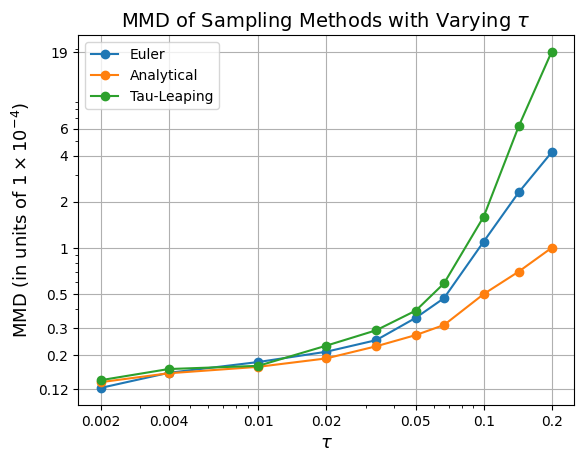

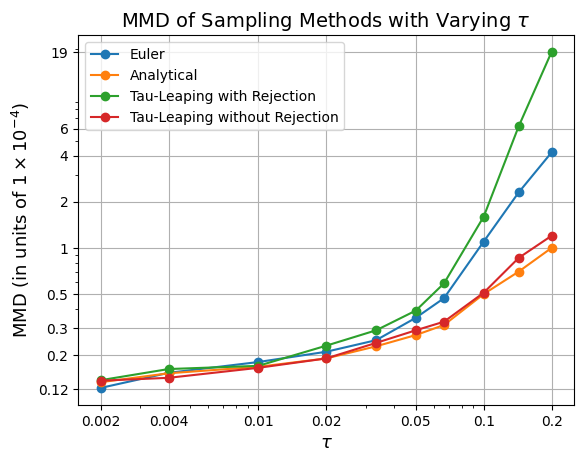

In [67]:
import numpy as np
import matplotlib.pyplot as plt

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500])
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500]), 3)
steps_y = [19, 6, 4, 2, 1, 0.5, 0.3, 0.2, 0.12]

mmd_lbjf = np.array([4.2, 2.3, 1.1, 0.47 ,0.35, 0.25, 0.21, 0.18, 0.153, 0.122])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.39, 0.29, 0.23, 0.17, 0.162, 0.137])
mmd_exact = np.array([1.0, 0.7, 0.5, 0.314, 0.27, 0.228, 0.19, 0.1675, 0.152, 0.133])
plt.plot(steps, mmd_lbjf , label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, mmd_exact, label='Analytical', marker='o')
plt.plot(steps, mmd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('MMD (in units of $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('mmd_plot_tau.pdf')
plt.show()


mmd_lbjf = np.array([4.2, 2.3, 1.1, 0.47 ,0.35, 0.25, 0.21, 0.18, 0.153, 0.122])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.39, 0.29, 0.23, 0.17, 0.162, 0.137])
mmd_exact = np.array([1.0, 0.7, 0.5, 0.314, 0.27, 0.228, 0.19, 0.1675, 0.152, 0.133])
mmd_taul_wo = np.array([1.2, 0.86, 0.51, 0.33, 0.29, 0.24, 0.19, 0.165, 0.142, 0.136])

plt.plot(steps, mmd_lbjf , label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, mmd_exact, label='Analytical', marker='o')
plt.plot(steps, mmd_taul, label='Tau-Leaping with Rejection', marker='o')
plt.plot(steps, mmd_taul_wo, label='Tau-Leaping without Rejection', marker='o')
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('MMD (in units of $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('mmd_plot_first20_worejection_tau.pdf')
plt.show()

In [ ]:
import numpy as np
steps = [750]
corrector = 10
sampler_name = ['TauL']# , CRMTauL']
for sampler_n_i in sampler_name:
    for step in steps:
        data_list = []
        for i in range(3):
            print(f'mnist_unet_corrector{corrector}_{sampler_n_i}{step}_mnist{i}.npy')
            data_list.append(np.load(f'mnist_unet_corrector{corrector}_01_{sampler_n_i}{step}_mnist{i}.npy'))
        data = np.vstack(data_list)
        print(data.shape)
        np.save(f'Samples/MNIST/mnist_unet_corrector{corrector}_01_{sampler_n_i}{step}.npy', data)
        

In [29]:
import numpy as np
max_t = 0.99999
min_t = 0.01
num_steps = [50, 100, 250, 500, 750, 1000]
nfe_10_01 = []
for steps in num_steps:
    ts = np.concatenate(
        (np.
        linspace(max_t, min_t, steps), np.array([0]))
    )
    print(len(ts))
    k = 0 
    for i, t in (enumerate(ts[0:-1])):
        print(i+1)
        if t <= 0.1:
            for j in range(1):
                k += 1
                print(k)
    print(i)
    print(i+k)
    nfe_10_01.append(i+k)
print(nfe_10_01)

51
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
1
47
2
48
3
49
4
50
5
49
54
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
1
92
2
93
3
94
4
95
5
96
6
97
7
98
8
99
9
100
10
99
109
251
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


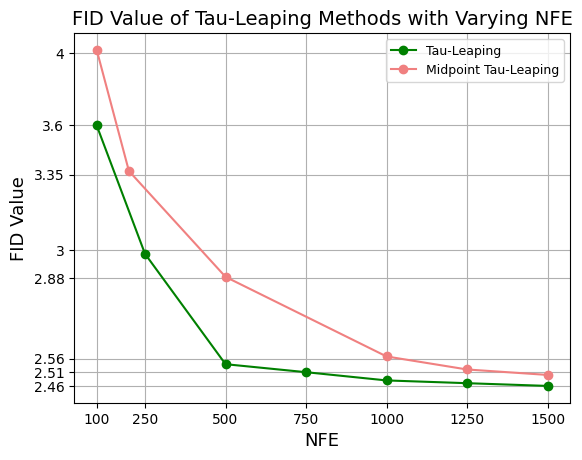

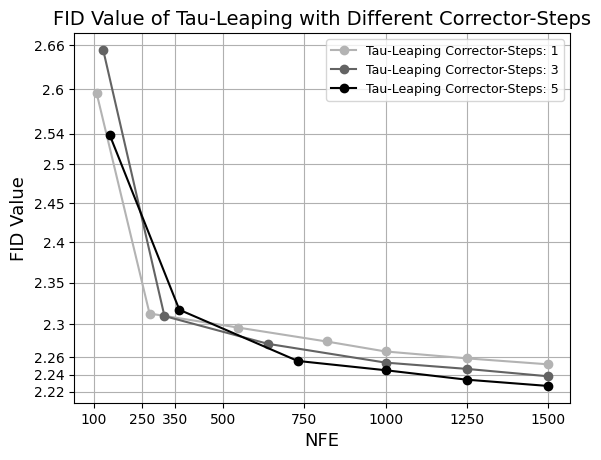

In [65]:
# nfe plot
import numpy as np
import matplotlib.pyplot as plt
"""
nfe_1_01 = [54, 109, 272, 545, 818, 1000] # 1090 last
nfe_1_01_fid = [13.172119479843474, 2.593958846497685, 2.3124636154390714,  2.2955929208740997, 2.268975460098858, 2.2571159746989906]
nfe_3_01 = [64, 129, 318, 637, 1000, 1272] # vorletzes 956
nfe_3_01_fid = [12.544362618674569, 2.653572526721007, 2.30941289542929, 2.276187915395326, 2.2539787186312788, 2.2466063307386435]
nfe_5_01 = [74, 149, 364, 729, 1000, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [12.58564395129946, 2.538496664948809, 2.3170141451028314, 2.2559381898192896, 2.2450412804101074, 2.2267139529323856]
nfe_10_01 = [99, 199, 479, 1000, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [11.713824326294798, 2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.195595756357534]  #3.195595756357534
nfe_mpl = [60, 100, 200, 500, 1000, 1500]
nfe_taul = [50, 100, 250, 500, 750, 1000, 1500]
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([13.453524786963495, 3.6, 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.460157370950734])
fid_mpl = np.array([12.394969584434108, 4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.48])
                                    # 30 (60), 50 (100), 100 (200), 250 (500), 500 (1000), 750 (1500)
"""

# nfe plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
nfe_1_01 = [109, 272, 545, 818, 1000, 1250, 1500] # 1090 last
nfe_1_01_fid = [2.593958846497685, 2.3124636154390714,  2.2955929208740997, 2.278975460098858, 2.2671159746989906, 2.259, 2.252]
nfe_3_01 = [129, 318, 637, 1000, 1250, 1500] # vorletzes 956 # 1272
nfe_3_01_fid = [2.653572526721007, 2.30941289542929, 2.276187915395326, 2.2539787186312788, 2.2466063307386435, 2.238]
nfe_5_01 = [149, 364, 729, 1000, 1250, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [ 2.538496664948809, 2.3170141451028314, 2.2559381898192896, 2.2450412804101074, 2.234, 2.2267139529323856]
nfe_10_01 = [199, 479, 1000, 1250, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.25, 2.195595756357534]  #3.195595756357534
nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

# steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([3.6, 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
fid_mpl = np.array([4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.52, 2.5])


#steps_plot = 

plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping', color='lightcoral')
#plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping C1')
#plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping C3')
#plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping C5')
#plt.plot(nfe_10_01, nfe_10_01_fid, marker='o', label='Tau-Leaping C10')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping Methods with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)

steps_y = [4, 3.6, 3.35, 3, 2.88, 2.56, 2.51, 2.46]
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
plt.yscale('log')
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_tau_mp_taul.pdf')
plt.show()


#plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping')
#plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping')
colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben

plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [2.66, 2.6, 2.54, 2.5, 2.45, 2.4, 2.35, 2.30, 2.26, 2.24, 2.22]
steps_plot = [100, 250, 350, 500, 750, 1000, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_tau_corrector.pdf')
plt.show()


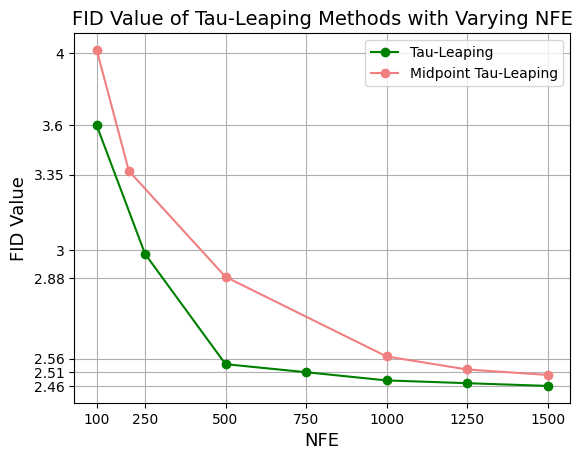

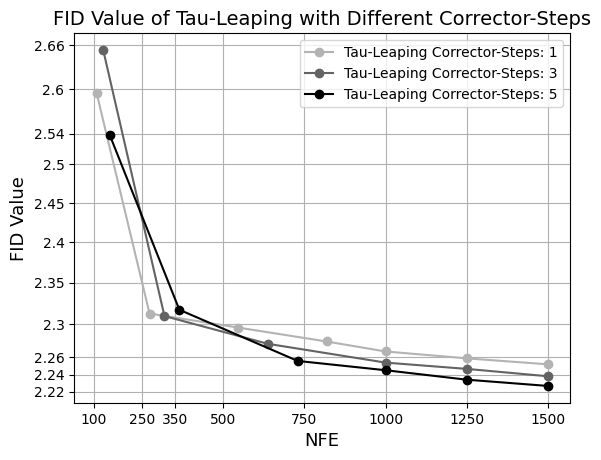

In [2]:
# NFE FID

import numpy as np
import matplotlib.pyplot as plt
"""
nfe_1_01 = [54, 109, 272, 545, 818, 1000] # 1090 last
nfe_1_01_fid = [13.172119479843474, 2.593958846497685, 2.3124636154390714,  2.2955929208740997, 2.268975460098858, 2.2571159746989906]
nfe_3_01 = [64, 129, 318, 637, 1000, 1272] # vorletzes 956
nfe_3_01_fid = [12.544362618674569, 2.653572526721007, 2.30941289542929, 2.276187915395326, 2.2539787186312788, 2.2466063307386435]
nfe_5_01 = [74, 149, 364, 729, 1000, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [12.58564395129946, 2.538496664948809, 2.3170141451028314, 2.2559381898192896, 2.2450412804101074, 2.2267139529323856]
nfe_10_01 = [99, 199, 479, 1000, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [11.713824326294798, 2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.195595756357534]  #3.195595756357534
nfe_mpl = [60, 100, 200, 500, 1000, 1500]
nfe_taul = [50, 100, 250, 500, 750, 1000, 1500]
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([13.453524786963495, 3.6, 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.460157370950734])
fid_mpl = np.array([12.394969584434108, 4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.48])
                                    # 30 (60), 50 (100), 100 (200), 250 (500), 500 (1000), 750 (1500)
"""

# nfe plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
nfe_1_01 = [109, 272, 545, 818, 1000, 1250, 1500] # 1090 last
nfe_1_01_fid = [2.593958846497685, 2.3124636154390714,  2.2955929208740997, 2.278975460098858, 2.2671159746989906, 2.259, 2.252]
nfe_3_01 = [129, 318, 637, 1000, 1250, 1500] # vorletzes 956 # 1272
nfe_3_01_fid = [2.653572526721007, 2.30941289542929, 2.276187915395326, 2.2539787186312788, 2.2466063307386435, 2.238]
nfe_5_01 = [149, 364, 729, 1000, 1250, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [ 2.538496664948809, 2.3170141451028314, 2.2559381898192896, 2.2450412804101074, 2.234, 2.2267139529323856]
nfe_10_01 = [199, 479, 1000, 1250, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.25, 2.195595756357534]  #3.195595756357534
nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

# steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
fid_taul = np.array([3.6, 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
fid_mpl = np.array([4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.52, 2.5])


#steps_plot = 

plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping', color='lightcoral')
#plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping C1')
#plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping C3')
#plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping C5')
#plt.plot(nfe_10_01, nfe_10_01_fid, marker='o', label='Tau-Leaping C10')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping Methods with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)

steps_y = [4, 3.6, 3.35, 3, 2.88, 2.56, 2.51, 2.46]
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
plt.yscale('log')
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.savefig('fid_nfe_mp_taul.pdf')
plt.show()


#plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping')
#plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping')
colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
fid_taul2 = np.array([2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
nfe_taul2 = [250, 500, 750, 1000, 1250, 1500]

#plt.plot(nfe_taul2, fid_taul2, marker='o', color='green', label='Tau-Leaping')
plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [2.66, 2.6, 2.54, 2.5, 2.45, 2.4, 2.35, 2.30, 2.26, 2.24, 2.22]
steps_plot = [100, 250, 350, 500, 750, 1000, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_nfe_corrector.pdf')
plt.show()

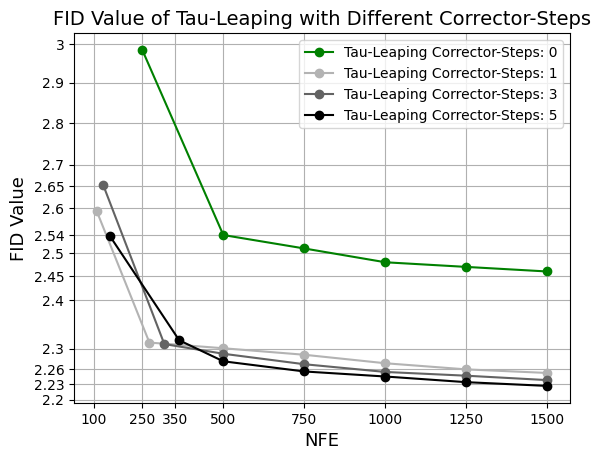

In [26]:
colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
fid_taul2 = np.array([2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
nfe_taul2 = [250, 500, 750, 1000, 1250, 1500]

nfe_1_01 = [109, 272, 500, 750, 1000, 1250, 1500] # 1090 last
nfe_1_01_fid = [2.593958846497685, 2.3124636154390714,  2.301, 2.288, 2.2711159746989906, 2.259, 2.252]
nfe_3_01 = [129, 318, 500, 750, 1000, 1250, 1500] # vorletzes 956 # 1272
nfe_3_01_fid = [2.653572526721007, 2.30941289542929, 2.29, 2.269187915395326, 2.2539787186312788, 2.2466063307386435, 2.238]
nfe_5_01 = [149, 364, 500, 750, 1000, 1250, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [ 2.538496664948809, 2.3170141451028314, 2.275, 2.2549381898192896, 2.2450412804101074, 2.234, 2.2267139529323856]
nfe_10_01 = [199, 479, 1000, 1250, 1500] # vorletztes # 959 letztes 1439
nfe_10_01_fid = [2.4731209322140444, 2.3148737019269277, 2.3065898535350584, 2.25, 2.195595756357534]  #3.195595756357534
nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

plt.plot(nfe_taul2, fid_taul2, marker='o', color='green', label='Tau-Leaping Corrector-Steps: 0')
plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [3, 2.9, 2.8, 2.7, 2.65, 2.6, 2.54, 2.5, 2.4, 2.45, 2.30, 2.26, 2.23, 2.2]
steps_plot = [100, 250, 350, 500, 750, 1000, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_nfe_corrector_taul.pdf')
plt.show()

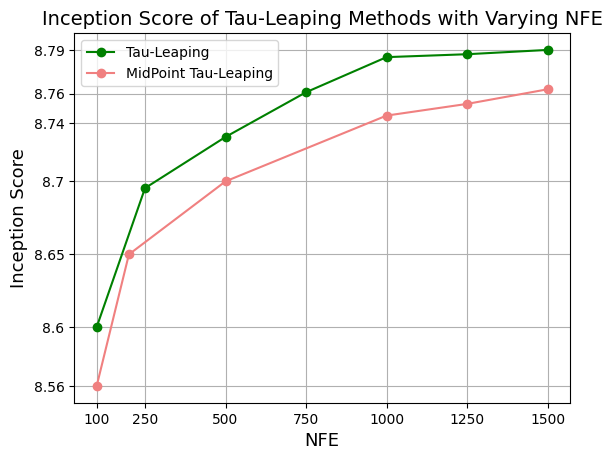

"\nplt.plot(steps, mean_is_taul, marker='o', color='green', label='Tau-Leaping')\nplt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],\n                 [mean + std for mean, std in zip(mean_is_taul, std_is_taul)],\n                 alpha=0.3, color='green')\n\nplt.plot(steps, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral')\nplt.fill_between(steps, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],\n                 [mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],\n                 alpha=0.3)\n\nplt.xlabel('$\\tau$', fontsize=13)\nplt.ylabel('Inception Score', fontsize=13)\nplt.title('Inception Score of Sampling Methods with Varying $\\tau$', fontsize=14)\nplt.legend()\nplt.grid(True)\nplt.xscale('log')\n#plt.yscale('log')\nplt.xticks(steps_plot, steps_plot)\nplt.savefig('inception_score_tau.pdf')\nplt.show()\n"

In [71]:
mean_is_taul = np.array([8.600311295819452, 8.695352062102907, 8.730387442552915, 8.76098102664333, 8.785004667417176, 8.787, 8.789941441541984])
std_is_taul = np.array([0.11749863261977536, 0.05961257597104094, 0.057613531976108634, 0.06736065870254852, 0.07408158674264428, 0.056, 0.07343111567356189])

mean_is_mpl = np.array([8.56, 8.65, 8.7, 8.745, 8.753, 8.763])
std_is_mpl = np.array([0.078, 0.1, 0.079, 0.06, 0.057, 0.075])
#50-100, 100-200, 250-500, 500-1000, 750, 1500

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])

nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

plt.plot(nfe_taul, mean_is_taul, marker='o', color='green', label='Tau-Leaping')
#plt.fill_between(nfe_taul, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],[mean + std for mean, std in zip(mean_is_taul, std_is_taul)],alpha=0.3, color='green')

plt.plot(nfe_mpl, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral')
#plt.fill_between(nfe_mpl, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],[mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],alpha=0.3)

plt.xlabel('NFE', fontsize=13)
plt.ylabel('Inception Score', fontsize=13)
plt.title('Inception Score of Tau-Leaping Methods with Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
steps_y = [8.56, 8.6,8.65, 8.7, 8.74, 8.76, 8.79]
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('inception_score_nfe_mp_taul.pdf')
plt.show()

nfe_1_01 = [54, 109, 272, 545, 818, 1000] # 1090 last
nfe_3_01 = [64, 129, 318, 637, 1000, 1272] # vorletzes 956
nfe_5_01 = [74, 149, 364, 729, 1000, 1500] #vorletztes 1094 letztes 15000
nfe_10_01 = [99, 199, 479, 1000, 1500] # vorletztes # 959 letztes 1439

mean_c1 = [7.685214153332941, 8.647939466433439, 8.755318814855267, 8.728635327016125, 8.769999551759987, 8.776702214194092]
std_c1 = [0.10020794506473688, 0.12287807651939232, 0.08248251060547318, 0.08304519492126802, 0.06759433319038019, 0.12659895249777367]

mean_c3 = [7.762886743437322, 8.596458341030935, 8.798446691296359, 8.751792345723775, 8.76805730506273, 8.74081231601401]
std_c3 = [0.11598291894202396, 0.09363631101316408, 0.10748087401514818, 0.09812815045935029, 0.05775935607353134, 0.09677611504981143]

mean_c5 = [7.665914862629701, 8.659614704761324, 8.795426848297684, 8.721246193397805, 8.74803374634143, 8.744422635144518]
std_c5 = [0.10402757843947735, 0.09600572858682611, 0.062457741056709454, 0.07043536838850206, 0.10784576786370587, 0.09917689867200492]

mean_c10 = [7.737014645693776, 8.671485752113487, 8.78130387956802, 8.763744669389167, 8.662650644054375]
std_c10 = [0.09972477960311658, 0.08709899412509303, 0.0974413469033469, 0.0987803915058357, 0.10316599969779615]

"""
plt.plot(steps, mean_is_taul, marker='o', color='green', label='Tau-Leaping')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],
                 [mean + std for mean, std in zip(mean_is_taul, std_is_taul)],
                 alpha=0.3, color='green')

plt.plot(steps, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral')
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 [mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 alpha=0.3)

plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('Inception Score', fontsize=13)
plt.title('Inception Score of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('inception_score_tau.pdf')
plt.show()
"""